In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Creating the Data

In [2]:
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y,noise=False):
        term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
        term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
        term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
        term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
        if noise==True:
            term5 = 0.2*np.random.normal(0,1,len(x))
            return term1+term2+term3+term4+term5
        else:
            return term1 + term2 + term3 + term4

z = FrankeFunction(x, y, noise=True)

## Plot of the Surface

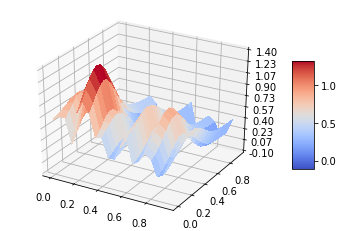

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## Creating the design Matrix

In [4]:
def create_X(x, y, n ):
        if len(x.shape) > 1:
                x = np.ravel(x)
                y = np.ravel(y)

        N = len(x)
        l = int((n+1)*(n+2)/2)          # Number of elements in beta                                                               
        X = np.ones((N,l))

        for i in range(1,n+1):
                q = int((i)*(i+1)/2)
                for k in range(i+1):
                        X[:,q+k] = (x**(i-k))*(y**k)

        return X

In [5]:
def MSE(y,ypred):
    MSE = np.mean((y-ypred)**2)
    return MSE

def R2(y,ypred):
    return 1-np.sum((y-ypred)**2)/np.sum((y-np.mean(y))**2)

def Scaling(X_train, X_test):
        
        if len(X_train[0,:]) <= 1:
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        else:
            scaler = StandardScaler()
            scaler.fit(X_train[:,1:])
            X_train = scaler.transform(X_train[:,1:])
            X_test = scaler.transform(X_test[:,1:])
            
            # Adding the intercept after the scaling, as the StandardScaler removes the 1s in the first column.
            intercept_train = np.ones((len(X_train),1))
            intercept_test = np.ones((len(X_test),1))
            X_train = np.concatenate((intercept_train,X_train),axis=1)
            X_test = np.concatenate((intercept_test,X_test),axis=1)
        return X_train, X_test

def OLSPredict(X_train, y_train):
    u, s, vt = np.linalg.svd(X_train, full_matrices=True)
    S = np.zeros((X_train.shape))
    S[:len(X_train[0,:]),:len(X_train[0,:])] = np.diag(s)
    XTX = vt.T.dot(S.T.dot(S)).dot(vt)

    # Estimating the Ordinary Least Squares Beta Matrix
    OLSbeta = np.linalg.pinv(XTX).dot(X_train.T).dot(y_train)
    return OLSbeta    
    

def OLSreg(X_train, X_test, z_train, z_test):
        
        # Decomposing (X_train * X_train.T) to avoid singular matrix when inverting
        u, s, vt = np.linalg.svd(X_train, full_matrices=True)
        smat = np.zeros((X_train.shape))
        smat[:len(X_train[0,:]),:len(X_train[0,:])] = np.diag(s)
        XTX = vt.T.dot(smat.T.dot(smat)).dot(vt)
        
        # Estimating the Ordinary Least Squares Beta Matrix
        OLSbeta = np.linalg.inv(XTX).dot(X_train.T).dot(z_train)
        
            
        # Making the prediciton
        z_tilde = X_train @ OLSbeta
        z_predict = X_test @ OLSbeta
        
        
        # Calculating the variance
        betavariance = np.sqrt(np.diagonal(np.linalg.inv(X_train.T.dot(X_train))*np.var(z_train-z_tilde)))
        
       
        return z_tilde, z_predict, betavariance, OLSbeta


## Ordinary Least Squares on the data set

The MSE for the prediciton is:
0.0022695738382534033 

The R2 for the prediciton is:
0.9727129741069986 



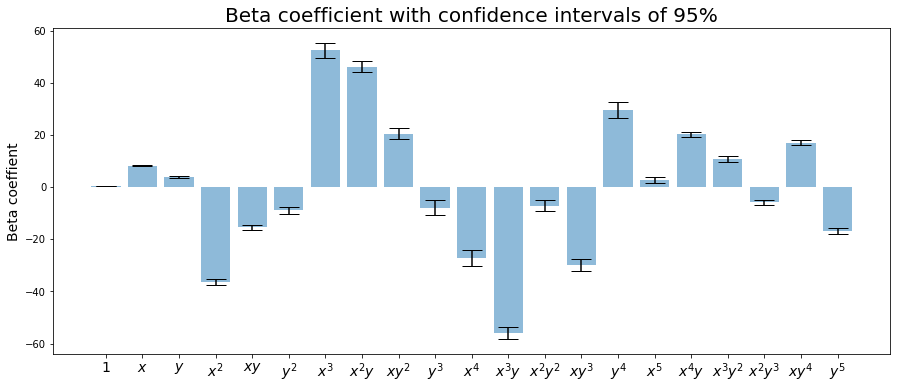

In [111]:
# Initializing the data
N = 5000
x, y = np.random.uniform(0,1,size=(2,N))
z = FrankeFunction(x, y,noise=False)


# Creating the design matrix
n=5 
X = create_X(x,y,n)
        
    
# Splitting into testing and training
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Computing Ordinary Least Squares and predicting
z_tilde, z_predict, betavariance, OLSbeta = OLSreg(X_train, X_test, z_train, z_test)

# Calculating the variance
betavariance = np.sqrt(np.diagonal(np.linalg.inv(X_train.T.dot(X_train))*np.var(z_train-z_tilde)))

print("The MSE for the prediciton is:")
print(MSE(z_test, z_predict), "\n")

print("The R2 for the prediciton is:")
print(R2(z_test, z_predict), "\n")




# Plotting the figure

fig, ax = plt.subplots(figsize=(15,6))

labels= ['1','$x$','$y$','$x^2$','$xy$','$y^2$','$x^3$','$x^2y$','$xy^2$','$y^3$','$x^4$',
         '$x^3y$','$x^2y^2$','$xy^3$','$y^4$','$x^5$','$x^4y$','$x^3y^2$','$x^2y^3$','$xy^4$','$y^5$']

x_pos = np.arange(len(labels))
ax.bar(x_pos, OLSbeta, 
       yerr=2*betavariance,
      alpha=0.5,
      capsize=10)
ax.set_ylabel('Beta coeffient', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=14)
ax.set_title('Beta coefficient with confidence intervals of 95%', fontsize=20)

plt.show()

## Part b): Bias-variance trade-off and resampling techniques.

In [112]:
N = 2000
x, y = np.random.uniform(0,1,size=(2,N))
z = FrankeFunction(x, y,noise=True)

# Array of polynomial degrees
n=np.arange(50)

TrainError = np.zeros(n.shape)
TestError = np.zeros(n.shape)



for i in range(len(n)):
    # Setting up the design matrix
    X = create_X(x,y,n[i])
    
    # Splitting into testing and training
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scaling the train and test set
    X_train, X_test = Scaling(X_train, X_test)

    
    # Decomposing (X_train * X_train.T) to avoid singular matrix when inverting
    u, s, vt = np.linalg.svd(X_train, full_matrices=True)
    S = np.zeros((X_train.shape))
    S[:len(X_train[0,:]),:len(X_train[0,:])] = np.diag(s)
    XTX = vt.T.dot(S.T.dot(S)).dot(vt)

    # Estimating the Ordinary Least Squares Beta Matrix
    OLSbeta = np.linalg.pinv(XTX).dot(X_train.T).dot(z_train)


    # Making the prediciton
    z_tilde = X_train @ OLSbeta
    z_predict = X_test @ OLSbeta

    
    
    
    # Computing the OLS prediction
    #z_tilde, z_predict, betavariance, OLSbeta = OLSreg(X_train, X_test, z_train, z_test)
    
    
    
    
    
    


    TrainError[i] = MSE(z_train, z_tilde)
    TestError[i] = MSE(z_test, z_predict)
    


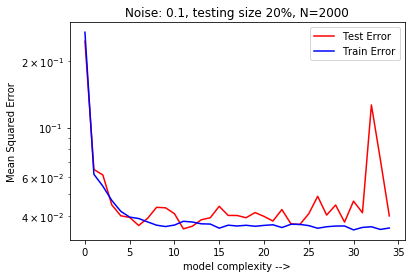

In [113]:
startpoint = 0
endpoint = 35
plt.plot(n[startpoint:endpoint],TestError[startpoint:endpoint],'r' ,label='Test Error')
plt.plot(n[startpoint:endpoint],TrainError[startpoint:endpoint],'b' ,label='Train Error')
plt.xlabel('model complexity -->')
plt.ylabel('Mean Squared Error')
plt.title("Noise: 0.1, testing size 20%, N=2000")
plt.yscale("log")
plt.legend()

## Incorporating bootstrap techniques

[2 4 3 ... 3 3 1]


In [114]:
def Resample(x,y):
    size = len(x)
    index = np.random.randint(1, size, size=size)
    x_ = x[index,:]
    y_ = y[index]
    return x_, y_

def OLSPredict(X_train, y_train):
    u, s, vt = np.linalg.svd(X_train, full_matrices=True)
    S = np.zeros((X_train.shape))
    S[:len(X_train[0,:]),:len(X_train[0,:])] = np.diag(s)
    XTX = vt.T.dot(S.T.dot(S)).dot(vt)

    # Estimating the Ordinary Least Squares Beta Matrix
    OLSbeta = np.linalg.pinv(XTX).dot(X_train.T).dot(y_train)
    return OLSbeta

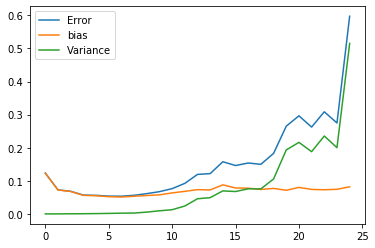

In [139]:
N = 700
n=np.arange(25)
n_bootstraps = 100


# Initalizing the dataset
x, y = np.random.uniform(0,1,size=(2,N))
z = FrankeFunction(x, y,noise=True)

error = np.zeros(n.shape)
bias = np.zeros(n.shape)
variance = np.zeros(n.shape)

# Creating design matrix for the maximum polynomial degree. 
X = create_X(x,y,n[-1])

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
# Scaling the train and test set
X_train, X_test = Scaling(X_train, X_test)

for i in range(len(n)):
    
    # How many columns of the design matrix allowed.
    q = int((i+1)*(i+2)/2)
    X_trainD = X_train[:,:q]
    X_testD = X_test[:,:q]
    
    # Setting up the array for the bootstrapped predictions
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    
    for j in range(n_bootstraps):
        x_,z_ = Resample(X_trainD, z_train)
        OLSbeta = OLSPredict(x_,z_)   
        z_pred[:,j] = X_testD @ OLSbeta 
    
    #Reshaping
    z_test = z_test.reshape(len(z_test),1)
    
    
    error[i] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias[i]  = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

plt.plot(n, error, label='Error')
plt.plot(n, bias, label='bias')
plt.plot(n, variance, label='Variance')
plt.legend()
plt.show()

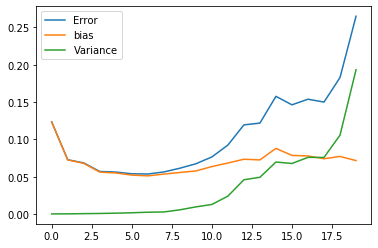

In [144]:
startpoint = 0
endpoint = 20

plt.plot(n[startpoint:endpoint], error[startpoint:endpoint], label='Error')
plt.plot(n[startpoint:endpoint], bias[startpoint:endpoint], label='bias')
plt.plot(n[startpoint:endpoint], variance[startpoint:endpoint], label='Variance')
plt.legend()
plt.show()

## Cross-Validation as resampling techniques, adding more complexity.

In [ ]:
# Initalizing
N = 700
n=np.arange(25)
folds = 5

# Initalizing the dataset
x, y = np.random.uniform(0,1,size=(2,N))
z = FrankeFunction(x, y,noise=True)





## Ridge Regression on the Franke fucntion with resampling

## Lasso Regression on the Franke function with resampling

## Introducing real data and preparing the data analysis